# Project - Computer Vision - Plant Seedlings Classification

## Description

The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of unique plants belonging to 12 species at several growth stages. There is dataset of  images of  plant seedlings at various stages of  grown.  Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the projectis to create a classifier capable of determining a plant's species from a photo.

## Objective

- To differentiate a weed from a crop seedling
- To build CNN model, that can effectively classify the plant's species.
- Improve crop yields and better stewardship of the environment.


## Data Dictionary

The data file names are:
- **images.npy** :  Images coverted to numpy object.
- **Label.csv** : Labels for the images - plant's species


## Index

- <a href = #link1>Overview of the dataset and Summary</a>

- <a href = #link2>Exploratory Data Analysis</a>


- <a href = #link3>Insights based on EDA</a> 


- <a href = #link4>Data pre-processing</a>


- <a href = #link5a>Data Compatability Operation</a> 

- <a href = #link5b>Model Building</a> 


- <a href = #link6>Model Performance Improvement</a>


- <a href = #link7>Model Performance Evaluation</a>

- <a href = #link8>Conclusion and key takeaways</a>


In [15]:
from google.colab import drive
drive.mount('/content/drive')

## <a id = "link1"></a> Overview of the dataset

**Importing necessary libraries**

In [53]:
#Reading the training images from the path and labelling them into the given categories
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns # for data visualization 
import tensorflow as tf
import keras
from sklearn.preprocessing import LabelEncoder
#ignoring warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.models import Sequential #sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam #optimiers for optimizing the model
from keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses, optimizers

# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)

# to suppress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Load dataset and Summary

In [21]:
image = np.load('/content/drive/MyDrive/images.npy')  #loading dataset from drive
cl_labels = pd.read_csv('/content/drive/MyDrive/Labels.csv')

In [22]:
image.shape

(4750, 128, 128, 3)

**There are 4750 images with size 128x128 RGB (3 Channels).**

In [23]:
print(cl_labels.nunique())
cl_labels.value_counts()

Label    12
dtype: int64


Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

**Datasets are not having equal representation of all the classes of plant seedlings.**

### Proportion of each Seedling classes

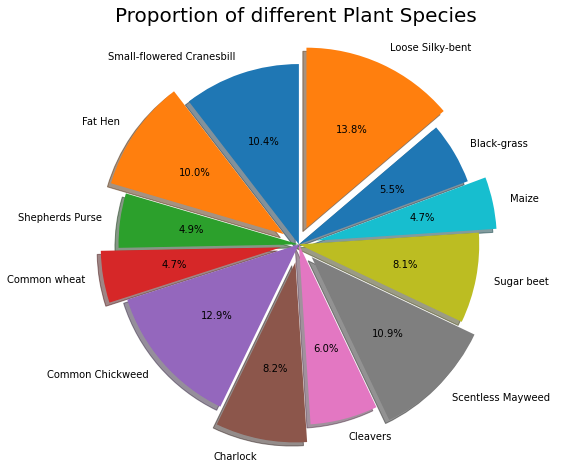

In [24]:
#plotting the pie chart 
lbls = ['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse', 'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers', 'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass', 'Loose Silky-bent']
count = []
for i in lbls:
    count.append(cl_labels.Label[cl_labels['Label'] == i ].count())
explode = (0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(count, explode = explode, labels=lbls, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of different Plant Species ", size = 20)
plt.show()

- Loose Silky-bent is having more samples in dataset, around 13.8% of total samples.
- Shepherds Purse, Common Wheat, Black grass are comparatively less number of samples in dataset
- There is good representation of weeds (Common Chickweed, Scentless Mayweed) in image dataset.

### Images from each class and their corresponding labels

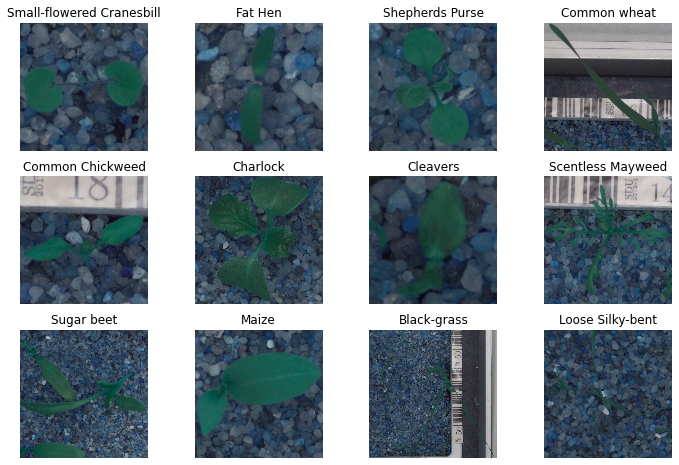

In [25]:
data = [[image[i],cl_labels.iloc[i].values[0]] for i in range(len(cl_labels))]
df = pd.DataFrame(data)
class_names =  cl_labels['Label'].unique().tolist()

plt.figure(figsize=(12,8))
for i,class_name in enumerate(class_names):
    for img, label in df[df[1]==class_name].head(1).values.tolist():
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

- Few plant seedlings classes seem hard to distinguish like Black-grass and Loose Silky-bent, so it might affect accuray of the model.

------

# <a id = "link2"></a> Exploratory Data Analysis

#### Mean Images for each class

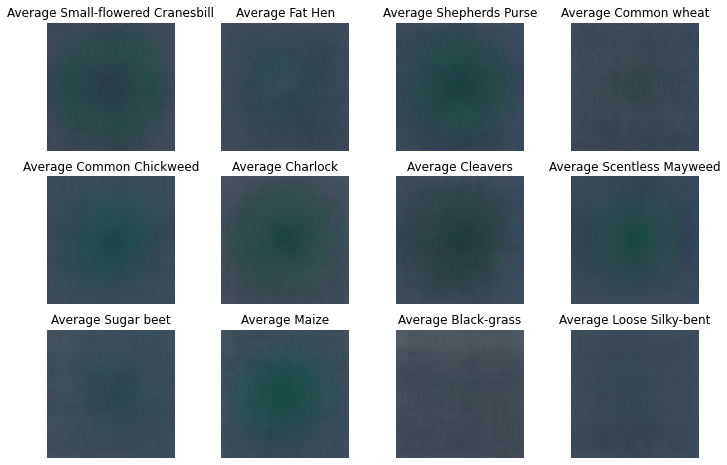

In [26]:
plt.figure(figsize=(12,8))
for i,class_name in enumerate(class_names):
    # calculate the average
    mean_img = np.mean(np.array((df[df[1]==class_name][0]).values.tolist()), axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape((128,128,3)).astype(np.uint8)
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(mean_img)
    plt.title(f'Average {class_name}')
    plt.axis('off')

- Black Grass, Loose Silky bent and Common wheat can be well differentiated from others species in mean-image.
- Among other species, Small-flowered cranesbill, Shepherds Purse are having more green contribution in mean-image.

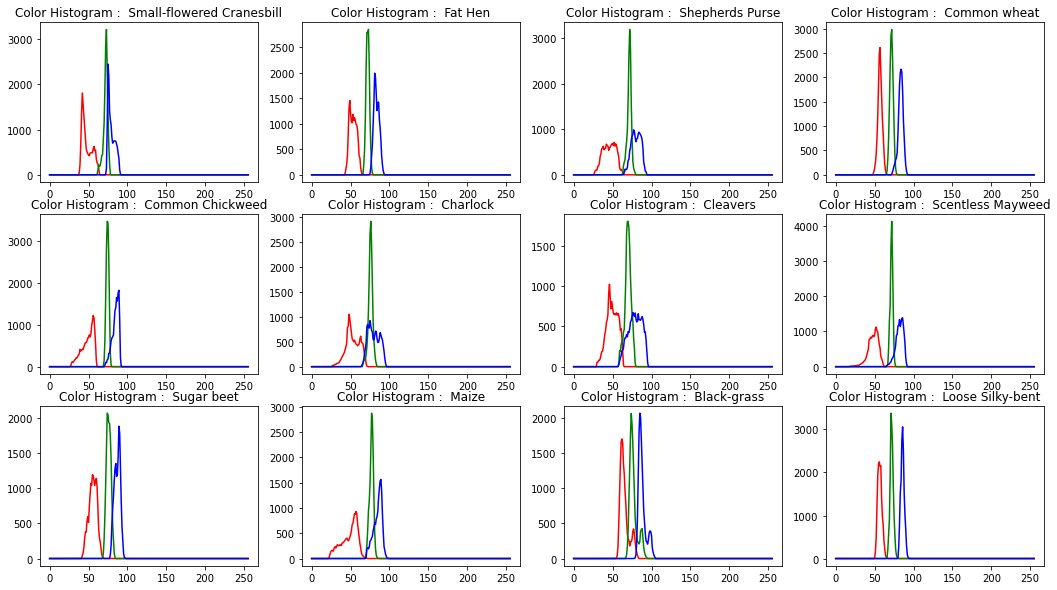

In [55]:
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)
plt.figure(figsize=(18,10))
# create the histogram plot, with three lines, one for
# each color

ax = plt.subplot(3, 4, i+1)

for i,class_name in enumerate(class_names):
    # calculate the average
    mean_img = np.mean(np.array((df[df[1]==class_name][0]).values.tolist()), axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape((128,128,3)).astype(np.uint8)
    ax = plt.subplot(3, 4, i+1)
    for channel_id, c in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            mean_img[:, :, channel_id], bins=256, range=(0, 256)
        )
        ax.plot(bin_edges[0:-1], histogram, color=c)
        plt.title(f'Color Histogram :  {class_name}')

- We can see the different histograms for RGB contribution in mean images of plant species.
- Among other species, Small-flowered cranesbill, Shepherds Purse are having more green contribution in mean-image.

--------

# <a id = "link3"></a> Insights based on EDA

1. There are 4750 samples of 12 different pland seedlings classes with size 128x128 RGB (3 Channels).
2. Datasets are not having equal representation of all the classes of plant seedlings.
3. Loose Silky-bent is having more samples in dataset, around 13.8% of total samples.
4. Shepherds Purse, Common Wheat, Black grass are comparatively less number of samples in dataset.
5. Few plant seedlings classes seem hard to distinguish like Black-grass and Loose Silky-bent, so it might affect accuray of the model.
6. There is good representation of weeds (Common Chickweed, Scentless Mayweed) in image dataset.
7. Black Grass, Loose Silky bent and Common wheat can be well differentiated from others species in mean-image.
8. Among other species, Small-flowered cranesbill, Shepherds Purse are having more green contribution in mean-image.

------

# <a id = "link4"></a> Data Pre - Processing

### Noise Removal from the images using Guassian Blurring

In [28]:
blurred_img = [cv2.GaussianBlur(image[i],(5,5),0) for i in range(len(image))] #using cv2 Gaussian blurring

### Normalization

In [31]:
blurred_img_norm = np.array(blurred_img)/255.0 #normalization

In [32]:
#gray image
gray_img = [cv2.cvtColor(image[i],cv2.COLOR_BGR2GRAY) for i in range(len(image))] #converting color to gray image 
blurred_gray_img = [cv2.blur(gray_img[i],(5,5)) for i in range(len(image))] 
blurred_gray_norm = np.array(blurred_gray_img)/255.0

### Images before and After the pre-processing steps

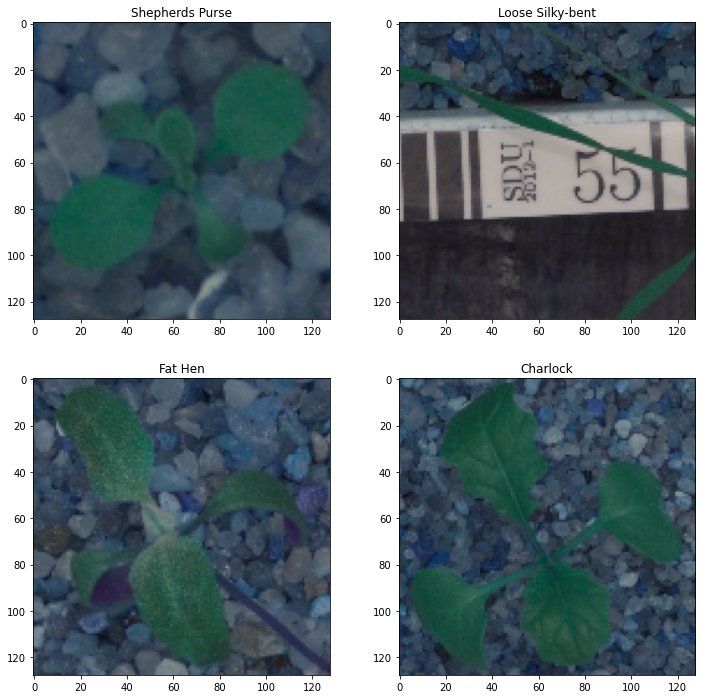

In [33]:
# vizualizing some random images with the labels
plt.figure(figsize=(12,12))
idx=[]
for i in range(4):
    index = randint(0, 4749)
    idx.append(index)
    plt.subplot(2,2,i+1)
    plt.imshow(image[index])
    plt.title(cl_labels.iloc[index].values[0])    
plt.show()

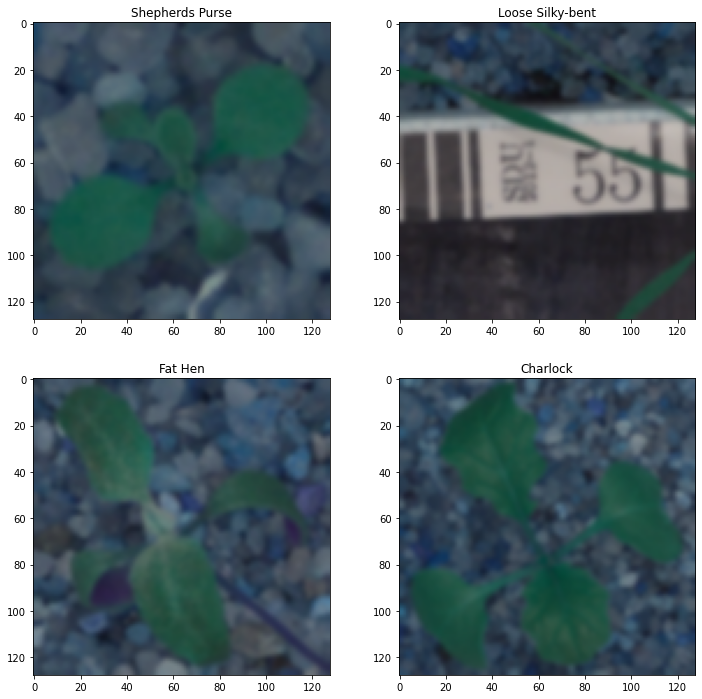

In [34]:
# vizualizing some random images with the labels
plt.figure(figsize=(12,12))
for i, index in enumerate(idx):
    plt.subplot(2,2,i+1)
    plt.imshow(blurred_img[index], cmap = 'gray')
    plt.title(cl_labels.iloc[index].values[0])    
plt.show()

**Gaussian Blurring and Normalization applied on the images**

## Gray Image - Pre and Post Gaussian Blurring and Normalization

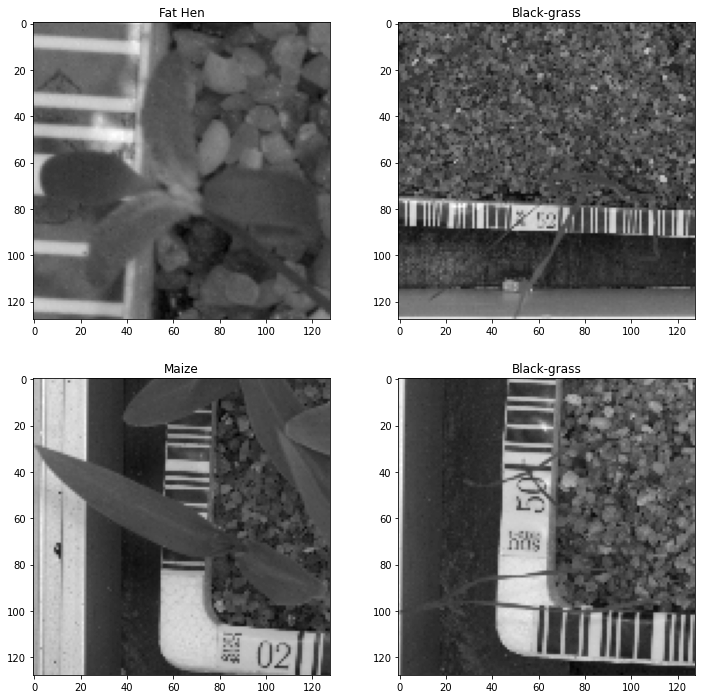

In [15]:
# vizualizing some random Gray images with the labels
plt.figure(figsize=(12,12))
idx=[]
for i in range(4):
    index = randint(0, 4749)
    idx.append(index)
    plt.subplot(2,2,i+1)
    plt.imshow(gray_img[index], cmap ='gray')
    plt.title(cl_labels.iloc[index].values[0])    
plt.show()

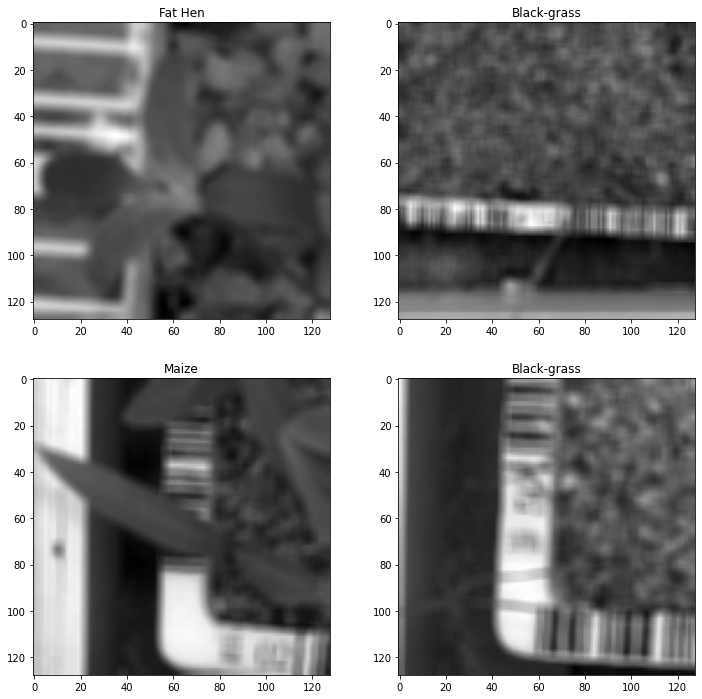

In [16]:
# vizualizing some random images with the labels
plt.figure(figsize=(12,12))
for i, index in enumerate(idx):
    plt.subplot(2,2,i+1)
    plt.imshow(blurred_gray_img[index], cmap = 'gray')
    plt.title(cl_labels.iloc[index].values[0])    
plt.show()

# Split the data into train and test

**For Model training, we are going here with the color blurred image, to retain the feature, as there are few plant species are hard to distinguish in gray images**

In [17]:
# Data Processing
i = 0
X_train = []
y_train = []

X_test = []
y_test = []

idx = np.random.permutation(len(image))
x,y = np.array(blurred_img_norm)[idx], np.array(cl_labels['Label'])[idx] #taking the normalized blurred img as input


for images,label in zip(x, y):
    i+=1
    if i < len(image)*.7:
        X_train.append(images)
        y_train.append(label)
    else:
        X_test.append(images)
        y_test.append(label)
X_train= np.array(X_train)
X_test = np.array(X_test)
print(X_train.shape)
print(X_test.shape)

# image reshaping 
X_train = X_train.reshape(-1,128,128,3)
X_test = X_test.reshape(-1,128,128,3)

(3324, 128, 128, 3)
(1426, 128, 128, 3)


**Vizualizing training images with the labels**

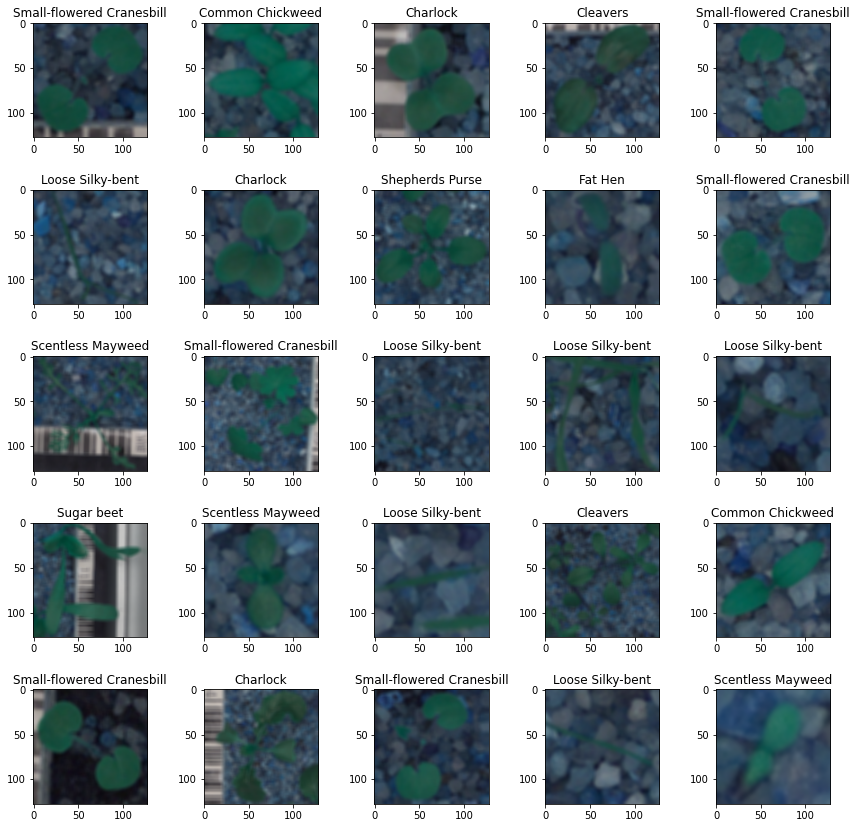

In [18]:
# vizualizing training images with the labels
plt.figure(figsize=(12,12))
for i in range(25):
    index = randint(0, 3324)
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[index])
    plt.title(y_train[index])
    plt.tight_layout()
plt.show()

-----

# <a id = "link5a"></a> Data compatiblity Operation

#### Label Encoding

**Coverting the categorical plant seedlings class into labels**

In [19]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [20]:
Categories = list(label_encoder.classes_)

#### One-Hot Encoding

In [21]:
encoded = to_categorical(y_train)
y_train_e=encoded
encoded_test = to_categorical(y_test)
y_test_e=encoded_test

## Shape of Dataset

**checking shape of image data and reshaping to ensure the dimensions.**

In [22]:
print(X_train.shape)
print(X_test.shape)

# image reshaping 
X_train = X_train.reshape(-1,128,128,3)
X_test = X_test.reshape(-1,128,128,3)

(3324, 128, 128, 3)
(1426, 128, 128, 3)


In [23]:
print(X_train.shape)
print(X_test.shape)

(3324, 128, 128, 3)
(1426, 128, 128, 3)


**Also we can see the data is already compatible with required shape**

-----

## <a id = "link5b"></a> Model Building

### Model 1 : Simple CNN architecuture with relu activation and adam optimizer

In [34]:
in_shape= X_train.shape[1:]  #shape of training dataset for the input to model

model1 = Sequential()
#
y_train=np.array(y_train)
model1.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = in_shape))
model1.add(MaxPool2D(pool_size=(2,2)))

#
model1.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

#
model1.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

#
model1.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))


#
model1.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))


# 
model1.add(Flatten())
model1.add(Dense(1024, activation = "relu"))

model1.add(Dense(12, activation = "softmax"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20) #early stopping
mc = ModelCheckpoint('best_model1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) #model saving

In [35]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 64)      4864      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       6

In [36]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999) #adam optimizer
model1.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 200  
batch_size = 64


history=model1.fit(X_train, 
          y_train_e,  #It expects integers because of the sparse_categorical_crossentropy loss function
          epochs=30, #number of iterations over the entire dataset to train on
          batch_size=64,validation_split=0.20,callbacks=[es,mc],use_multiprocessing=True)#number of samples per gradient update for training  


Epoch 1/30
42/42 [==============================] - 11s 199ms/step - loss: 2.3021 - accuracy: 0.2162 - val_loss: 1.8997 - val_accuracy: 0.3429

Epoch 00001: val_accuracy improved from -inf to 0.34286, saving model to best_model1.h5
Epoch 2/30
42/42 [==============================] - 6s 144ms/step - loss: 1.7028 - accuracy: 0.4111 - val_loss: 1.5080 - val_accuracy: 0.4331

Epoch 00002: val_accuracy improved from 0.34286 to 0.43308, saving model to best_model1.h5
Epoch 3/30
42/42 [==============================] - 6s 144ms/step - loss: 1.3670 - accuracy: 0.5314 - val_loss: 1.3020 - val_accuracy: 0.5173

Epoch 00003: val_accuracy improved from 0.43308 to 0.51729, saving model to best_model1.h5
Epoch 4/30
42/42 [==============================] - 6s 143ms/step - loss: 1.0800 - accuracy: 0.6363 - val_loss: 1.0657 - val_accuracy: 0.6165

Epoch 00004: val_accuracy improved from 0.51729 to 0.61654, saving model to best_model1.h5
Epoch 5/30
42/42 [==============================] - 6s 143ms/step 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


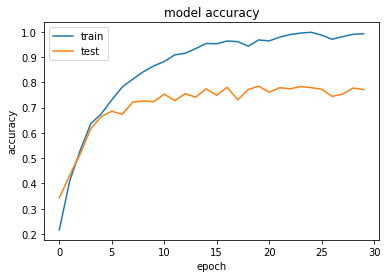

In [37]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [38]:
#evaluation on test set
model1.evaluate(X_test,y_test_e)

45/45 [==============================] - 2s 37ms/step - loss: 1.5294 - accuracy: 0.7721


[1.5294160842895508, 0.7720897793769836]

In [39]:
# Test Prediction 
y_test_pred = model1.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_pred_prob = np.max(y_test_pred, axis=1)

In [40]:
accuracy_score(np.array(y_test), y_test_pred_classes)

0.7720897615708275

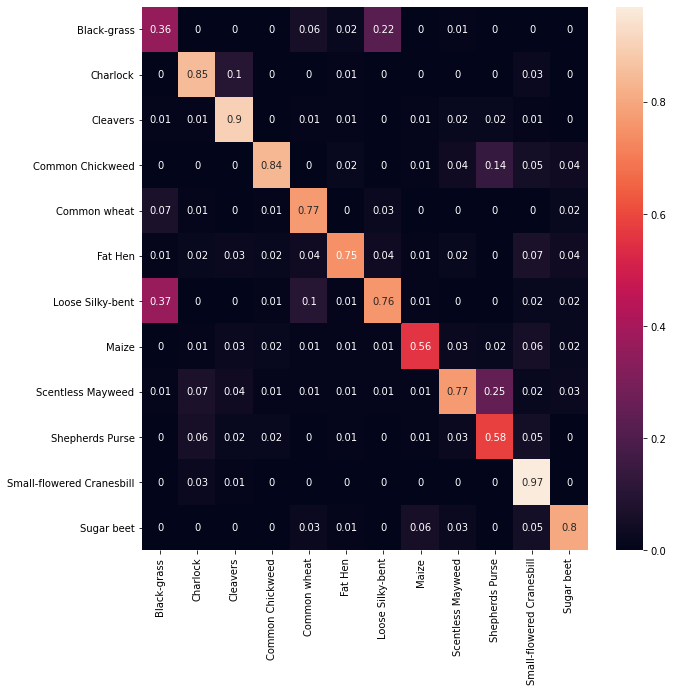

In [41]:
cf_matrix = confusion_matrix(np.array(y_test), y_test_pred_classes)

# Confusion matrix normalized per category true value
cf_matrix_n1 = np.round(cf_matrix/np.sum(cf_matrix, axis=1), 2)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix_n1,xticklabels=Categories, yticklabels=Categories, annot=True)

- Here we can see, there is high variance in the accuracy and model is overfitted on the training dataset.
- To improve the model, reducing the variance and genralize it better, we would need to impplement some regularization technique.
- In later model architecture, we are going to explore different regularization technique and activation function to improve the model.

# <a id = "link6"></a> Model Performance Improvement

### Model 2: Adding dropout to the model for reducing the variance of model (regularization)

In [93]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
in_shape= X_train.shape[1:]
model2 = Sequential()
#
y_train=np.array(y_train)
model2.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = in_shape))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
#
model2.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.25))
#
model2.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.3))
#
model2.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.3))

#
model2.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.3))

# 
model2.add(Flatten())
model2.add(Dense(1024, activation = "relu"))
model2.add(Dropout(0.5))
model2.add(Dense(12, activation = "softmax"))

In [94]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 64)      4864      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 128)      

In [96]:

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 200  
batch_size = 64


history2=model2.fit(X_train, 
          y_train_e,  #It expects integers because of the sparse_categorical_crossentropy loss function
          epochs=30, #number of iterations over the entire dataset to train on
          batch_size=64,validation_split=0.20,callbacks=[es,mc],use_multiprocessing=True)#number of samples per gradient update for training  


Epoch 1/30
42/42 [==============================] - 8s 167ms/step - loss: 2.4360 - accuracy: 0.1350 - val_loss: 2.4340 - val_accuracy: 0.1383

Epoch 00001: val_accuracy improved from -inf to 0.13835, saving model to best_model2.h5
Epoch 2/30
42/42 [==============================] - 7s 155ms/step - loss: 2.4201 - accuracy: 0.1384 - val_loss: 2.4228 - val_accuracy: 0.1278

Epoch 00002: val_accuracy did not improve from 0.13835
Epoch 3/30
42/42 [==============================] - 6s 154ms/step - loss: 2.2517 - accuracy: 0.2426 - val_loss: 2.1780 - val_accuracy: 0.2632

Epoch 00003: val_accuracy improved from 0.13835 to 0.26316, saving model to best_model2.h5
Epoch 4/30
42/42 [==============================] - 6s 153ms/step - loss: 1.8072 - accuracy: 0.3780 - val_loss: 1.6957 - val_accuracy: 0.4180

Epoch 00004: val_accuracy improved from 0.26316 to 0.41805, saving model to best_model2.h5
Epoch 5/30
42/42 [==============================] - 6s 153ms/step - loss: 1.6679 - accuracy: 0.4197 - v

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


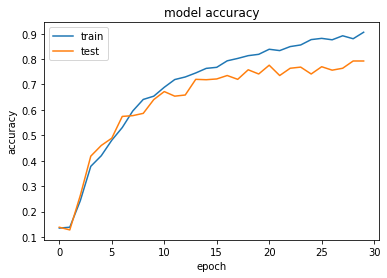

In [97]:
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [98]:
#evaluation on test set
model2.evaluate(X_test,y_test_e)

45/45 [==============================] - 1s 28ms/step - loss: 0.5843 - accuracy: 0.8079


[0.584313154220581, 0.8078541159629822]

In [99]:
# Test Prediction 
y_test_pred = model2.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_pred_prob = np.max(y_test_pred, axis=1)

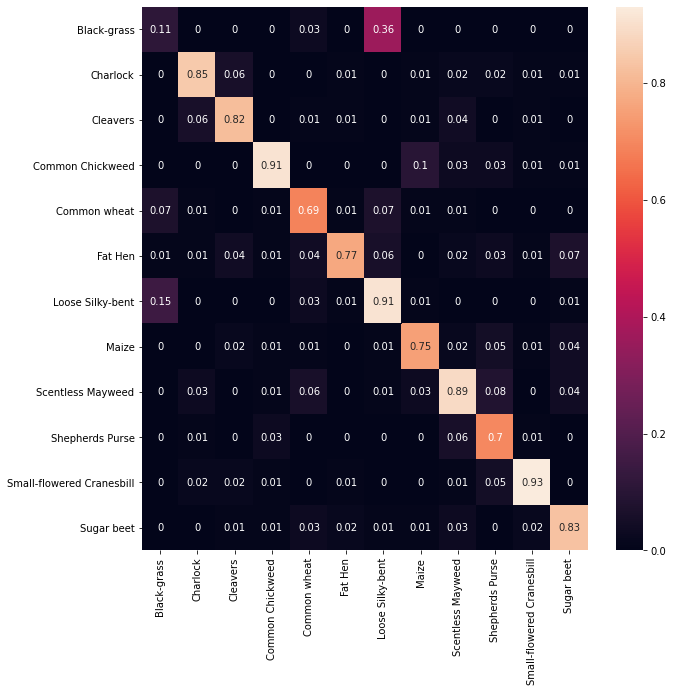

In [100]:
cf_matrix = confusion_matrix(np.array(y_test), y_test_pred_classes)
# Confusion matrix normalized per category true value
cf_matrix_n1 = np.round(cf_matrix/np.sum(cf_matrix, axis=1), 2)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix_n1,xticklabels=Categories, yticklabels=Categories, annot=True)

- Variance is comparatively reduced, and accuracy of the model on validation set is also improved.
- We will check other activation function as well to explore if we can enhance the accuracy further.

### Model 3:  Activaton Function - Leaky ReLU, Optimizer - Adam

In [24]:
class conv_Layers:
   
  def __init__(self, nfilters, kernel_size, stride=1, 
               pool_size=2, leakyrelu_slope=0.1, dropc=0.0, bnorm=False):
    self.nfilters = nfilters
    self.kernel_size = kernel_size
    self.stride = stride
    self.pool_size = pool_size
    self.leakyrelu_slope = leakyrelu_slope
    self.dropfrac = dropc
    self.bnorm = bnorm
  
  def __call__(self, x):
    x = Conv2D(self.nfilters, kernel_size=self.kernel_size, 
               strides=self.stride, padding='same')(x)
    x = LeakyReLU(self.leakyrelu_slope)(x)
    if (self.dropfrac > 0.0): 
      x = Dropout(self.dropfrac)(x)
    if (self.bnorm):
      x = BatchNormalization()(x)
    x = MaxPool2D(self.pool_size)(x)
    return x

class dense_Layers:

  def __init__(self, nunits, leakyrelu_slope=0.1, dropd=0.0, bnorm=False):
    self.nunits = nunits
    self.leakyrelu_slope = leakyrelu_slope 
    self.dropfrac = dropd
    self.bnorm = bnorm

  def __call__(self, x):
    x = Dense(self.nunits)(x)
    x = LeakyReLU(self.leakyrelu_slope)(x)
    if (self.dropfrac > 0.0):
      x = Dropout(self.dropfrac)(x)
    if (self.bnorm):
      x = BatchNormalization()(x)
    return x


In [25]:
def LNmodel(in_shape, conv_filters, dense_filters, kernel_size, num_classes, lr,
            stride=1, pool_size=2, leakyrelu_slope=0.1, dropc=0.0, dropd=0.0, bnorm=False):

  in_shape = X_train.shape[1:]
  i = Input(shape=in_shape)
  for ncl, nconvfilters in enumerate(conv_filters):
    if (ncl==0):
      x = conv_Layers(nconvfilters, kernel_size,
                      stride, pool_size, leakyrelu_slope, dropc, bnorm)(i)
    else:
      x = conv_Layers(nconvfilters, kernel_size,
                      stride, pool_size, leakyrelu_slope, dropc, bnorm)(x)

  x = Flatten()(x)

  for ndl, ndunits in enumerate(dense_filters):
    x = dense_Layers(ndunits, leakyrelu_slope, dropd, bnorm)(x)

  x = Dense(num_classes, activation='softmax')(x)

  ln_model  = Model(inputs=i, outputs=x)
  adam = optimizers.Adam(learning_rate=lr)
  ln_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  return ln_model

In [26]:
lr = 0.001
kernelsize = 3
in_shape= X_train.shape[1:]
model3 = LNmodel(in_shape, [64,128,256], [1024,256], kernelsize, 12, lr,
                    stride=1, pool_size=2, leakyrelu_slope=0.1, dropc=0.25,
                    dropd=0.5, bnorm=False)
model3.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0     

In [27]:

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history3 = model3.fit(X_train, y_train_e, 
                                  validation_split=0.2,
                                  verbose=1, batch_size=64,
                                  shuffle=True, epochs=60,callbacks=[es,mc])

Epoch 1/60
42/42 [==============================] - 42s 275ms/step - loss: 2.6786 - accuracy: 0.1956 - val_loss: 1.8893 - val_accuracy: 0.3850

Epoch 00001: val_accuracy improved from -inf to 0.38496, saving model to best_model3.h5
Epoch 2/60
42/42 [==============================] - 10s 239ms/step - loss: 1.6808 - accuracy: 0.4257 - val_loss: 1.9444 - val_accuracy: 0.3398

Epoch 00002: val_accuracy did not improve from 0.38496
Epoch 3/60
42/42 [==============================] - 10s 238ms/step - loss: 1.3515 - accuracy: 0.5382 - val_loss: 2.1897 - val_accuracy: 0.3624

Epoch 00003: val_accuracy did not improve from 0.38496
Epoch 4/60
42/42 [==============================] - 10s 238ms/step - loss: 1.1854 - accuracy: 0.5886 - val_loss: 2.0145 - val_accuracy: 0.3639

Epoch 00004: val_accuracy did not improve from 0.38496
Epoch 5/60
42/42 [==============================] - 10s 237ms/step - loss: 1.0465 - accuracy: 0.6551 - val_loss: 2.4279 - val_accuracy: 0.3414

Epoch 00005: val_accuracy d

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


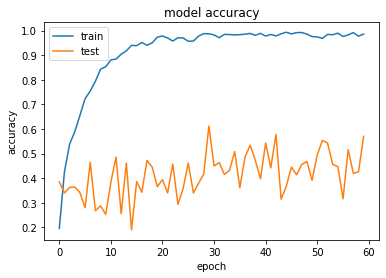

In [28]:
print(history3.history.keys())
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [29]:
# Test Prediction 
y_test_pred = model3.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_pred_prob = np.max(y_test_pred, axis=1)

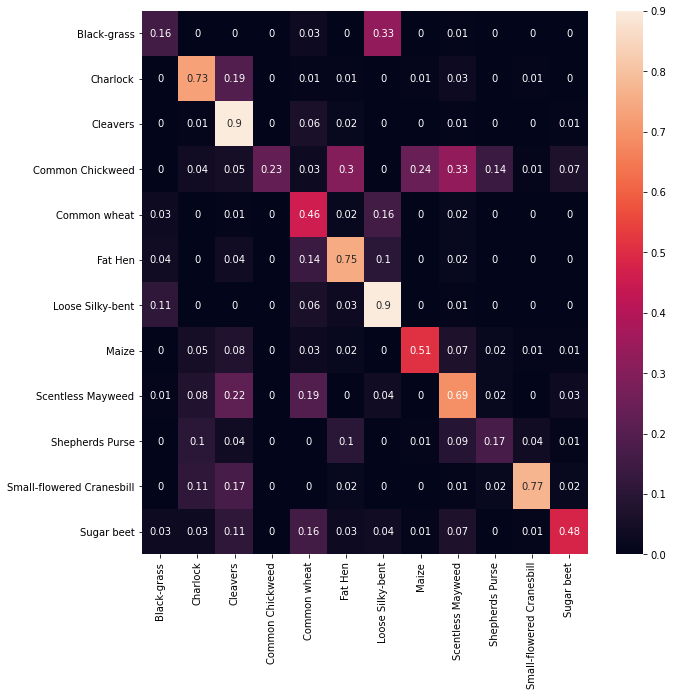

In [30]:
cf_matrix = confusion_matrix(np.array(y_test), y_test_pred_classes)

# Confusion matrix normalized per category true value
cf_matrix_n1 = np.round(cf_matrix/np.sum(cf_matrix, axis=1), 2)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix_n1,xticklabels=Categories, yticklabels=Categories, annot=True)

- We can see here in this model architecture, accuracy is imapcted in validtion set.
- In this architecture, we have tried to generalize the model building and implemented Leaky-ReLU activation function.
- In comparing all these three models, Model2 is perofroming better.

-------

## <a id = "link7"></a> Model Performance Evaluation

In [101]:
#evaluation on test set
model1.evaluate(X_test,y_test_e)

45/45 [==============================] - 1s 28ms/step - loss: 1.5294 - accuracy: 0.7721


[1.5294160842895508, 0.7720897793769836]

In [102]:
#evaluation on test set
model2.evaluate(X_test,y_test_e)

45/45 [==============================] - 1s 27ms/step - loss: 0.5843 - accuracy: 0.8079


[0.584313154220581, 0.8078541159629822]

In [103]:
#evaluation on test set
model3.evaluate(X_test,y_test_e)

45/45 [==============================] - 2s 36ms/step - loss: 2.8102 - accuracy: 0.5975


[2.8101961612701416, 0.5974754691123962]

-------

In [12]:
comparison_frame = pd.DataFrame({'Model':['Model1 : CNN Model with Relu Activation and Adam Optimizer','Model 2 : Regualarized CNN Model (Dropout Included)',
                                          'Model3 - Leaky Relu Activation and Adam Optimizer'], 'Training Accuracy':[0.992,0.905,0.986], 'Validation Accuray':[0.784,0.792,0.612], 'Test Set Accuray':[0.772,0.807,0.597], 'Remarks':['High Variance, Overfitted on Training Set','Improved and Reqularized Model','High Variance and Low Accuracy']}) 
comparison_frame

Model  Training Accuracy  \
0  Model1 : CNN Model with Relu Activation and Ad...              0.992   
1  Model 2 : Regualarized CNN Model (Dropout Incl...              0.905   
2  Model3 - Leaky Relu Activation and Adam Optimizer              0.986   

   Validation Accuray  Test Set Accuray  \
0               0.784             0.772   
1               0.792             0.807   
2               0.612             0.597   

                                     Remarks  
0  High Variance, Overfitted on Training Set  
1             Improved and Reqularized Model  
2             High Variance and Low Accuracy

- **In comparison among all three models, Model2 is relatively performing better and can be considered a better model for the implementation.**

---

### Confusion Matrix

In [112]:
def confusion_matrix_plot(model):
  y_test_pred = model.predict(X_test)
  y_test_pred_classes = np.argmax(y_test_pred, axis=1)
  y_test_pred_prob = np.max(y_test_pred, axis=1)
  cf_matrix = confusion_matrix(np.array(y_test), y_test_pred_classes)
  # Confusion matrix normalized per category true value
  cf_matrix_n1 = np.round(cf_matrix/np.sum(cf_matrix, axis=1), 2)
  plt.figure(figsize=(10,10))
  sns.heatmap(cf_matrix_n1,xticklabels=Categories, yticklabels=Categories, annot=True)

**Model1**

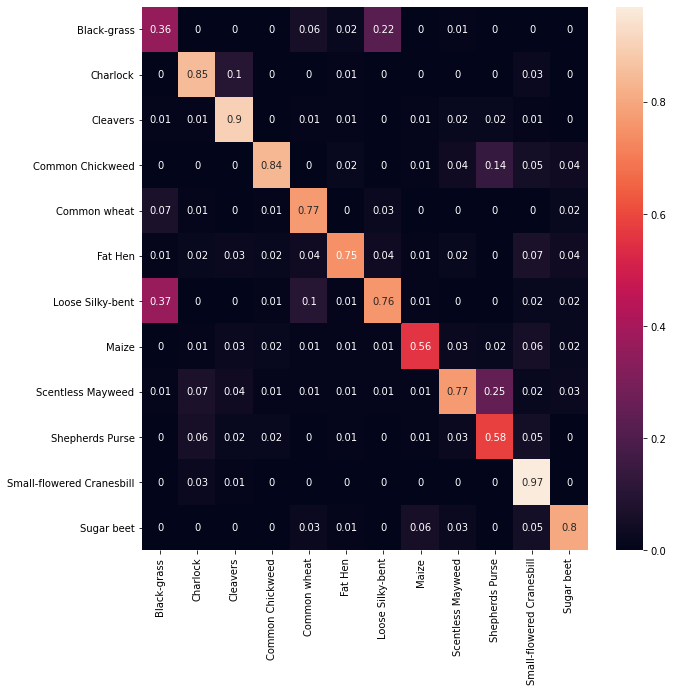

In [113]:
confusion_matrix_plot(model1)

- We can see the classification/ detection of plant species like Black Grass and Loose Silky-bent is not well performed model and seemed to be confused between two.
- Also Model is classiying scentless mayweed as Shepherds Purse in 25% of its sample.

**Model2**

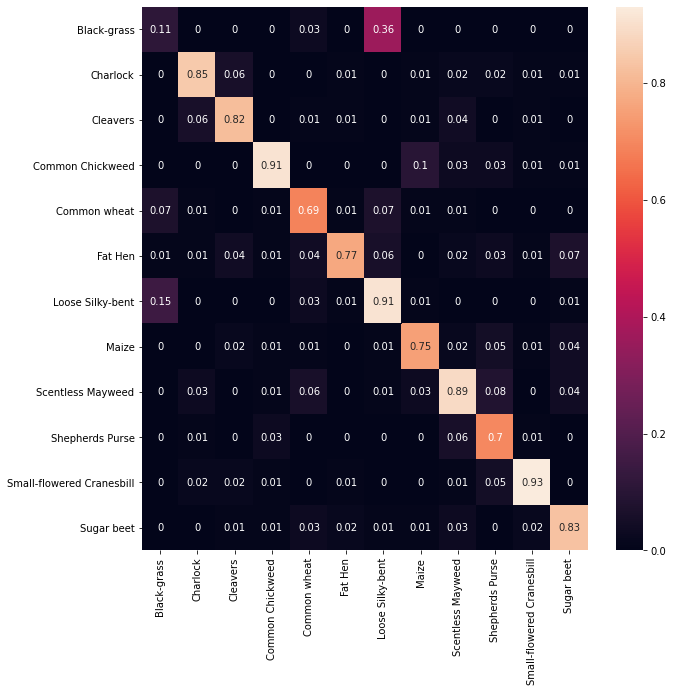

In [114]:
confusion_matrix_plot(model2)

- Here this Model is able to differentiate between scentless mayweed and Shepherds well.
- But still there is lot misclassification in Black Grass and Loose Silky-bent.

**Model3**

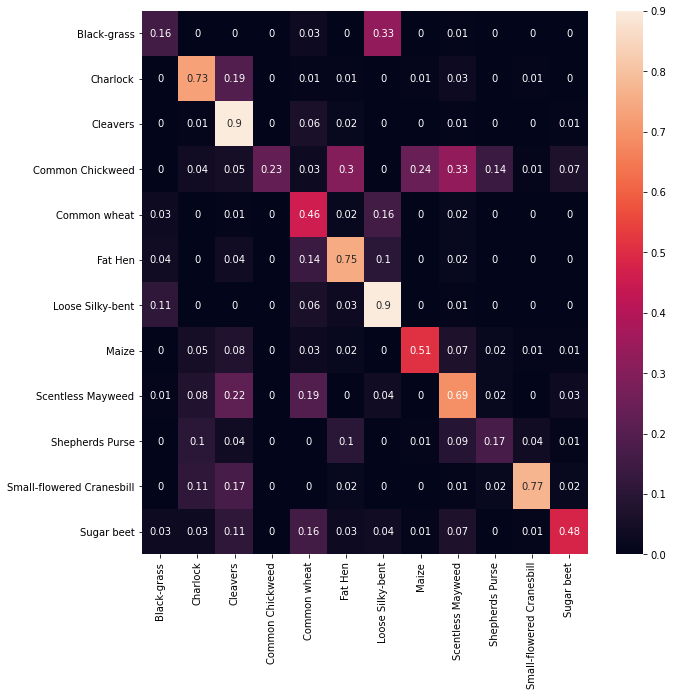

In [116]:
confusion_matrix_plot(model3)

- Model3 seems to be struggling in classifying the palnt speies and there a lot of misclassification in most of the palnt species.

### Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59] - Model2

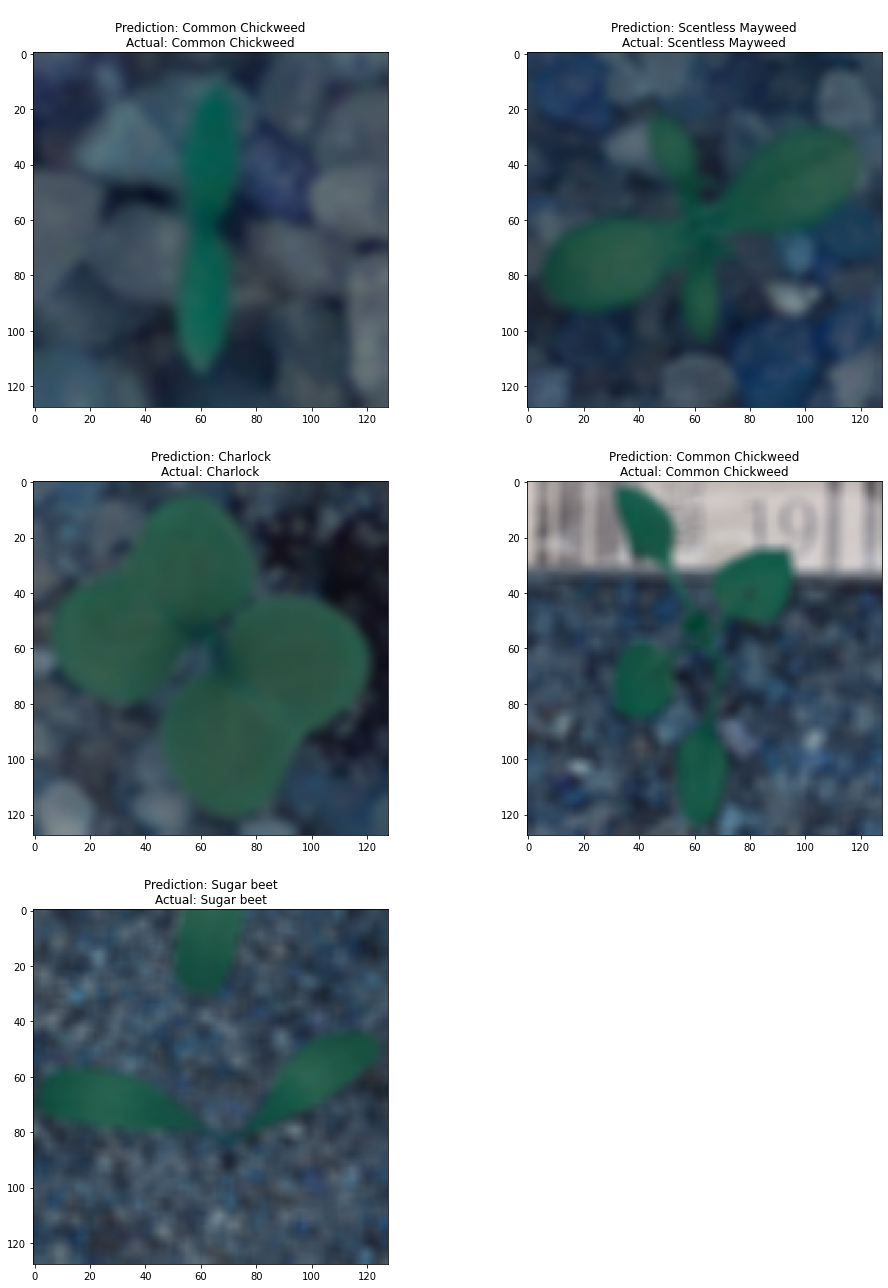

In [105]:
# visualizing prediction and actual labels of plant seedlings from model2 (best model architecture among three)
chk = [2,3,33,36,59]
plt.figure(figsize=(15,18))
for i,n  in enumerate(chk):
    plt.subplot(3,2,i+1)
    plt.imshow(X_test[n]) #plant seedlings
    ttl = '\n'+'Prediction: ' + str(Categories[np.argmax(model2.predict(X_test)[n])]) + '\n'+'Actual: ' + str(Categories[y_test[n]])
    plt.title(ttl) 
    plt.tight_layout()   
plt.show()

- **We can see all the test samples have been classified correctly.**
- Model 2 is giving the convincing classification result, though there are species like Black Grass and Loose Silky bent, where model struggles to distinguish.

# <a id = "link8"></a> Conclusion and key takeaways 

**We have build the classifier capable of determining a plant's species from the given species with 80% of accuracy. There are few conclusions that can be made through the model exploration process :** 


1. Regularized model with adam optimizer and ReLU activation, is relatively perofrmed better among other model arcitecture.

2. There is still scope for improvement in the test accuracy and F1 score of the CNN model chosen here. Different architectures can be built and hyperparamter tuning can be performed to obtain a better brain tumor classifier.

3. We can visualize the filters and understand why the model does not do well in the differentiation of Black Grass and Loose Silky bent plants species.

4. Few images in plant species, appeared to be quite similar in feature and hard to distinguish through the built model as well.

5. In give test sample for evaluation, we have achieved all the correct classifications.

**Thus, the built CNN model can be well utilized by the authority to detect different plant species/weed and to improve crop yields and better stewardship of the environment.**